## Select GPU

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

!nvidia-smi

## Import Required Libraries

In [15]:
import torch
import timeit
import os
import copy
import random
import numpy as np

from gene import Gene
from dataset import ROCTDataset
from elastic_mobilenet import ElasticMobileNet
from elastic_resnet import ElasticResNet
from validation_utils import calibrate_batchnorm, accuracy_metric_numpy, calculate_net_size_from_mobilenet_config, calculate_net_size_from_resnet_config

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Load Settings

In [ ]:
import json
with open('config-mobilenet-ROCT.json') as f:
    config = json.load(f)
# print(config)
init_config = config['initialization']
ofa_settings = config['ofa_settings']

config

## Initialize Dataloader and OFA Network

In [4]:
labels = ['NORMAL', 'CNV', 'DME', 'DRUSEN']

BATCH_SIZE = 48
SOFT_BATCH = 8

input_dim = 224

val_set = ROCTDataset(labels=labels, dataset_type='val', input_dim=input_dim, data_dir='data/Retinal OCT Eval')
val_generator = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

test_set = ROCTDataset(labels=labels, dataset_type='test', input_dim=input_dim, data_dir='data/Retinal OCT Eval')
test_generator = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Params Elastic Kernel
expanding_kernels=init_config['expanding_kernels']

# Params Elastic Width
keep_channel_order=init_config['keep_channel_order']

input_dim=init_config['input_dim']

output_n=init_config['output_n']
kernels=init_config['kernels']
max_depth=init_config['max_depth']
sections=init_config['sections']

net = ElasticMobileNet(input_dim=input_dim, 
                    output_n=output_n, 
                    max_depth=max_depth, 
                    expanding_kernels=expanding_kernels,
                    keep_channel_order=keep_channel_order,
                    kernels=kernels,
                    sections=sections,
                    bn_track_running_stats=True).to(device)

if init_config['pretrained_weights_dir']:
    net.load_my_state_dict(torch.load(init_config['pretrained_weights_dir']))

## Evaluation Function

In [12]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def calculate_ROCs(y_test, y_pred, n_classes=4):

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    y_test = np.eye(n_classes)[y_test]
    
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds['micro'] = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc

def calculate_confusion_matrix(y_test, y_pred, n_classes=4):
    y_pred = np.argmax(y_pred, 1)
    cm = confusion_matrix(y_test, y_pred)
    return ":".join([str(n) for r in cm for n in r])
    

def evaluate_net(net, test_generator, val_generator, score_metric_fn, net_type='mobilenet'):
    
    copy_net = copy.deepcopy(net)

    print('Calibrating batchnorm...')
    calibrate_batchnorm(copy_net, val_generator)
    print('--- Done')

    avg_score = []
    avg_latency = []
    all_outputs = []
    all_labels = []
    all_X = []

    with torch.no_grad():
        copy_net.eval()
        j = -1
        for X, y in tqdm(test_generator):
            j += 1

            X, y = X.to(device), y.cpu().numpy()
            copy_net.enable_sampling_mode()
            start_time = timeit.default_timer()

            output = copy_net(X)

            avg_latency += [timeit.default_timer() - start_time]
            output = output.cpu().numpy()
            all_outputs += list(output)
            all_labels += list(y)
            all_X += [X.cpu().numpy()]

            if j == 0:
                param_size = copy_net.calculate_param_size() /1000 /1000
                feature_size = copy_net.calculate_feature_size() /1000 /1000
                if net_type == 'mobilenet':
                    _, flops_count = calculate_net_size_from_mobilenet_config(copy_net)
                else:
                    _, flops_count = calculate_net_size_from_resnet_config(copy_net)

            copy_net.disable_sampling_mode()
    
    all_outputs, all_labels = np.asarray(all_outputs), np.asarray(all_labels)
    roc_auc = calculate_ROCs(all_labels, all_outputs)
    cm = calculate_confusion_matrix(all_labels, all_outputs)
    avg_score = score_metric_fn(all_outputs, all_labels)

    avg_latency = np.mean(avg_latency, axis=0)

            
    return avg_latency, avg_score, param_size, feature_size, flops_count, roc_auc[0], roc_auc[1], roc_auc[2], roc_auc[3], roc_auc['micro'], cm, all_outputs, all_labels, all_X

## Sample and Inference

Calibrating batchnorm...
--- Done


  0%|          | 0/21 [00:00<?, ?it/s]

Sampled Subnet Configurations:
sections_configuration: 5
depth_configuration: [1, 1, 1, 1, 3]
kernels_configuration: [7, 7, 3, 7, 3, 5, 7, 7, 7, 3, 3, 3, 7, 7, 3, 5]
width_configuration: [32, 32, 32, 64, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512]
input_resolution: 160
width_expansion_configuration: [4, 4, 6, 4, 3, 3, 3, 3, 4, 6, 3, 6, 6, 3, 6, 6]

avg_latency : 0.008442384811739126
avg_score : 0.986
param_size : 7.286444
feature_size : 171.44544
flops_count : 274.5408
roc_auc_0 : 0.9999680000000001
roc_auc_1 : 0.9960853333333333
roc_auc_2 : 0.9914026666666668
roc_auc_3 : 0.9997066666666666
roc_auc_micro : 0.9967499999999999
cm : 250:0:0:0:0:248:1:1:1:8:241:0:1:2:0:247

Sample inference:


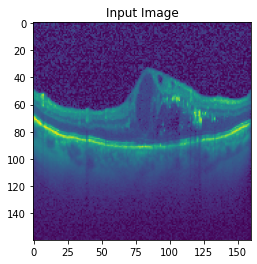

Prediction: [-4.654578  -2.3507922  8.918703  -4.8329   ] (2 - DME)
Truth: 2 - DME


In [32]:
settings = {
    'resolutions': [160, 192],
    'kernels': [3,5,7],
    'sections': [5],
    'max_depth': 3,
    'initial_channel': 16,
    'width_selection': [2], # 2 for mobilenet, [1,2] for resnet
    'width_expansion_ratios': [3,4,6], # comment for resnet
    'output_n': 4
}

gene = Gene(settings=settings, properties={}, configurations={}, net_type='mobilenet')
properties = gene.export_properties()
configurations = gene.export_configurations()
net.load_configuration(configurations)
test_generator.dataset.set_input_dim(randomize=True, permute_from=[net.input_resolution])
val_generator.dataset.set_input_dim(randomize=True, permute_from=[net.input_resolution])

metrics = evaluate_net(net, test_generator, val_generator, score_metric_fn=accuracy_metric_numpy, net_type='mobilenet')
columns = ['avg_latency', 'avg_score', 'param_size', 'feature_size', 'flops_count', 'roc_auc_0', 'roc_auc_1', 'roc_auc_2', 'roc_auc_3', 'roc_auc_micro', 'cm', 'all_outputs', 'all_labels', 'all_X']

print('Sampled Subnet Configurations:')
for k,v in configurations.items():
    print('{}: {}'.format(k,v))
print()

for i in range(len(metrics) - 3):
    print(columns[i], ':', metrics[i])
    
print()
print('Sample inference:')
plt.title('Input Image')
plt.imshow(metrics[-1][0][0,0])
plt.show()

labels = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
print('Prediction:', metrics[-3][0], '({} - {})'.format(np.argmax(metrics[-3][0]), labels[np.argmax(metrics[-3][0])]))
print('Truth:', metrics[-2][0], '-', labels[metrics[-2][0]])